In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
from ts_tools import *

In [3]:
#load train
store_sales = pd.read_csv(
    'input_data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index('date').sort_index()

#load test
test = pd.read_csv(
    'input_data/test.csv',
    usecols=['store_nbr', 'family', 'date', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index('date').sort_index()

In [4]:
full = pd.concat([store_sales, test])

In [5]:
full['day'] = full.index.day_of_week
full['week'] = full.index.week
full['month'] = full.index.month
full['year'] = full.index.year

## Look at the data

In [6]:
#Look at the data
fl = full.loc[full.store_nbr == '1']
fl = fl.groupby(['date', 'family'])['sales'].sum().unstack('family')

In [7]:
cols = fl.columns

#### $Total$

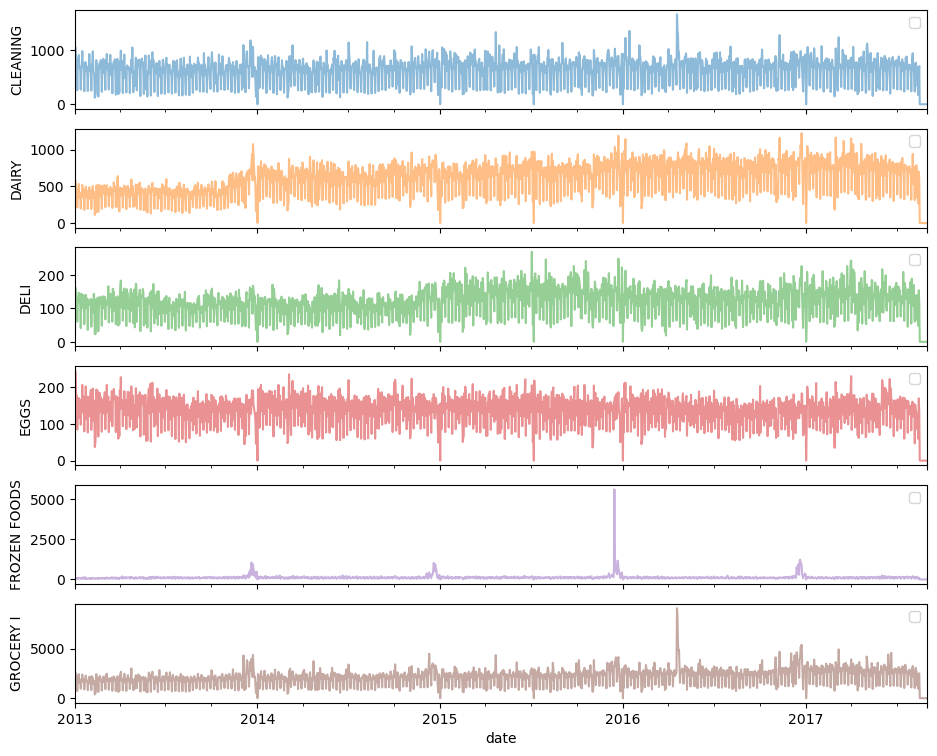

In [8]:
axs = fl.loc[:, cols[7:13]].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
for ax, family in zip(axs, cols[7:13]):
    ax.legend([])
    ax.set_ylabel(family)

###### `There is a little ascending trend and yearly cycles`

#### $Yearly$

In [9]:
fl = fl.loc['2015']

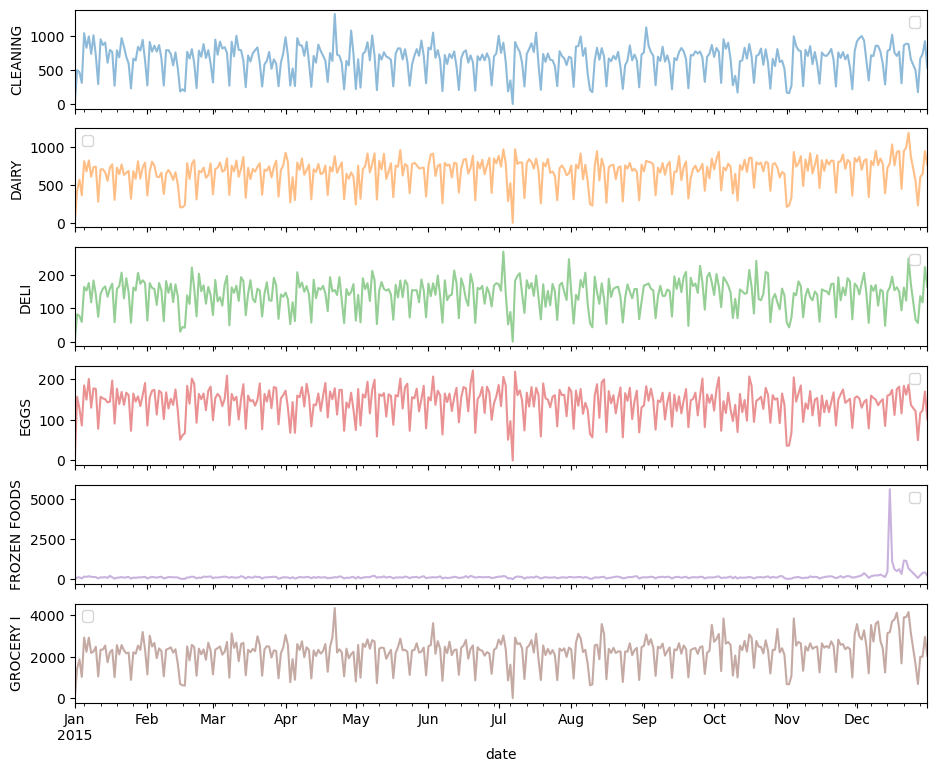

In [10]:
axs = fl.loc[:, cols[7:13]].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
for ax, family in zip(axs, cols[7:13]):
    ax.legend([])
    ax.set_ylabel(family)

###### `There're might be weekly cycles`

## Seasonal check

In [11]:
fl = full.loc[full.store_nbr == '1']
fl = fl.loc['2015']

#### Check for weekly cycles

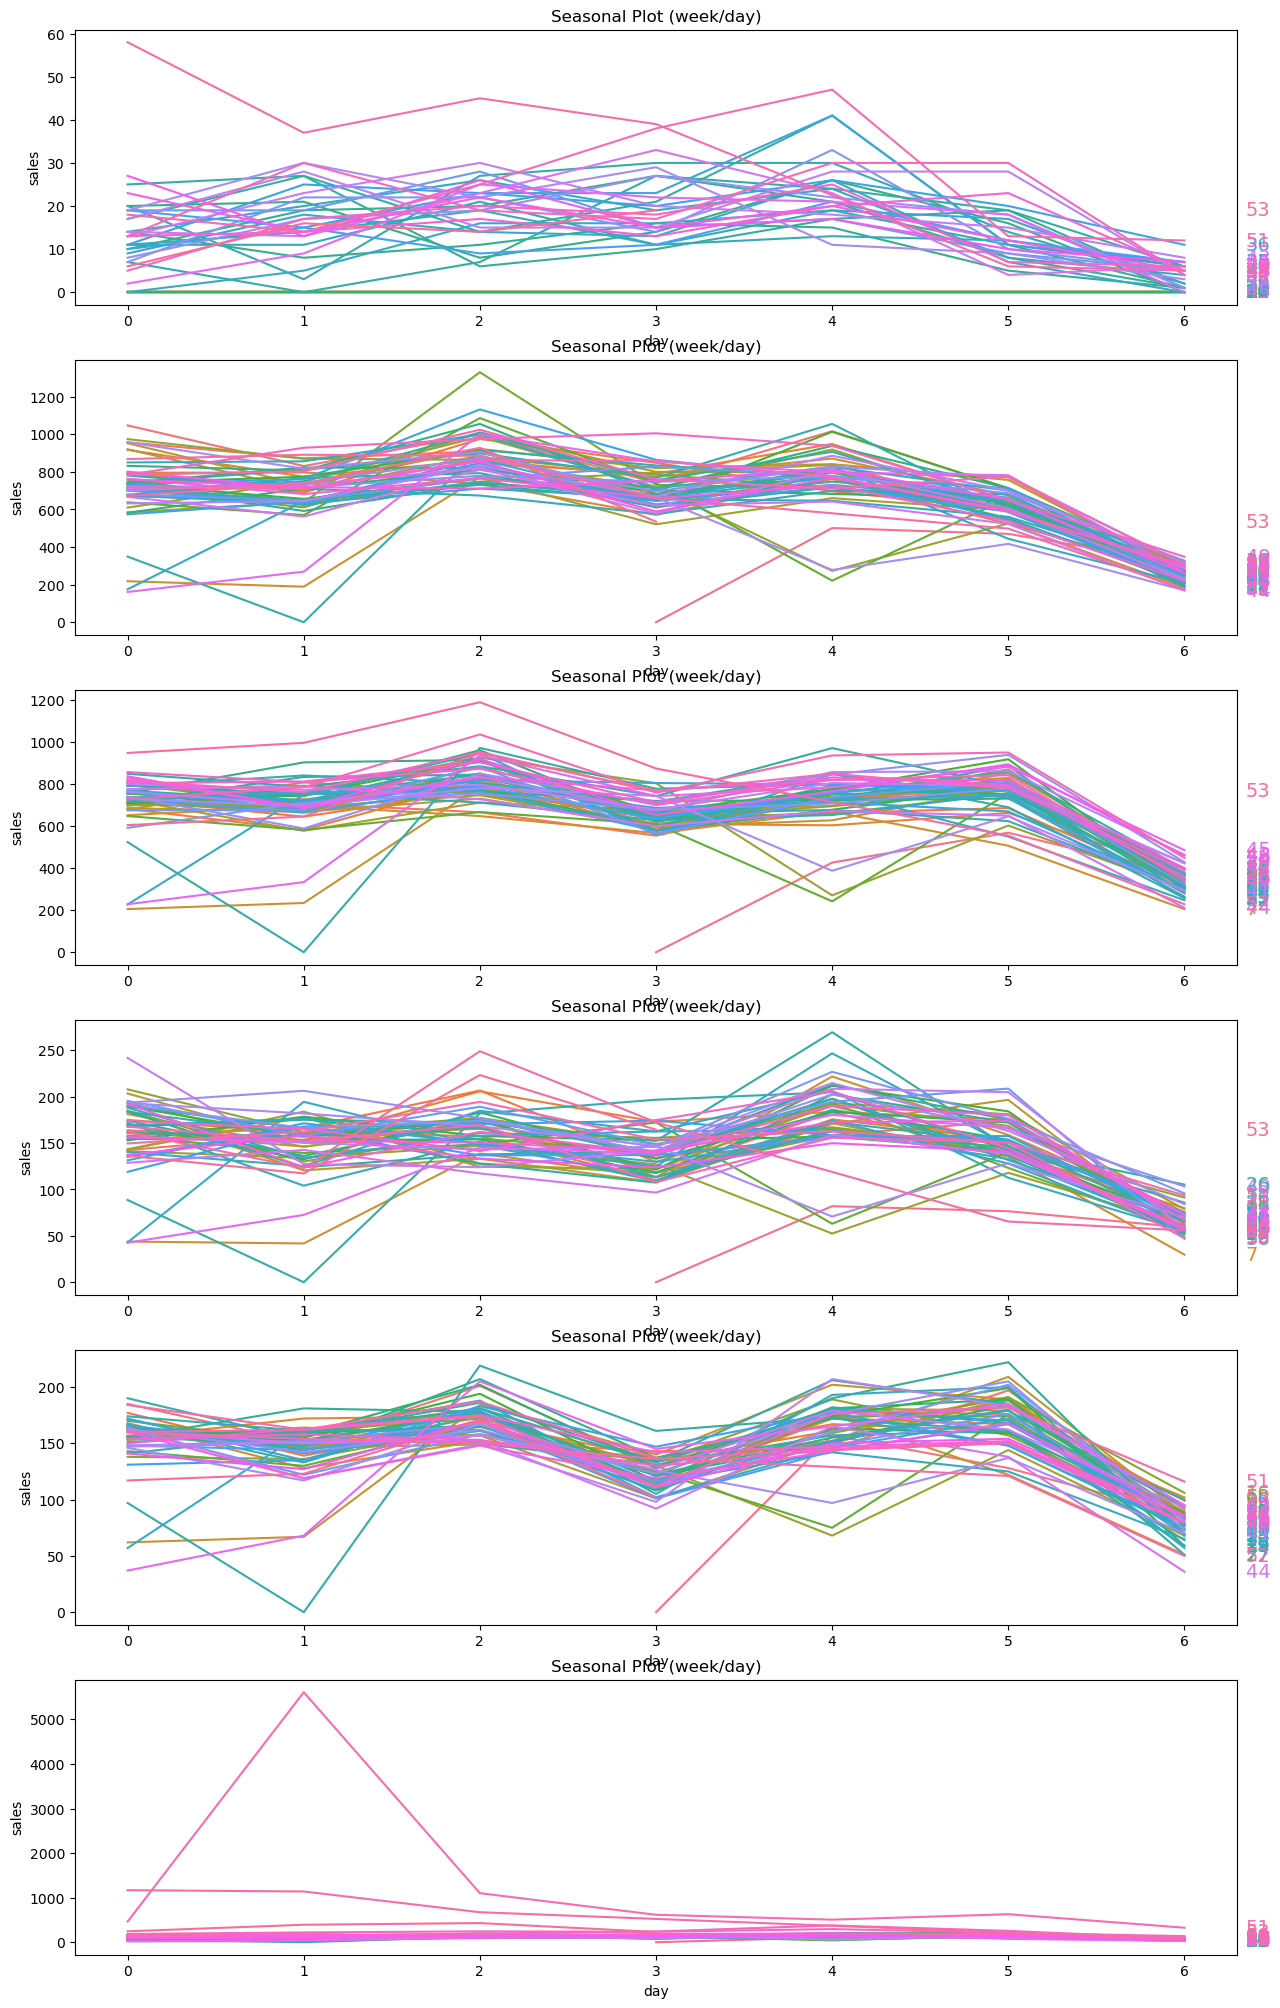

In [12]:
fig, axes = plt.subplots(6, 1, figsize = (15,25))
for n, ax in enumerate(fig.get_axes()):
    seasonal_plot(X = fl.loc[fl.family == cols[n+6], ['week', 'day']],
                  y = fl.loc[fl.family == cols[n+6], 'sales'], period = 'week', freq = 'day', ax=ax)
plt.show()

###### `We can easily recognize weekly cycles`

In [13]:
fl = full.loc[full.store_nbr == '1']

#### Check for yearly cycles

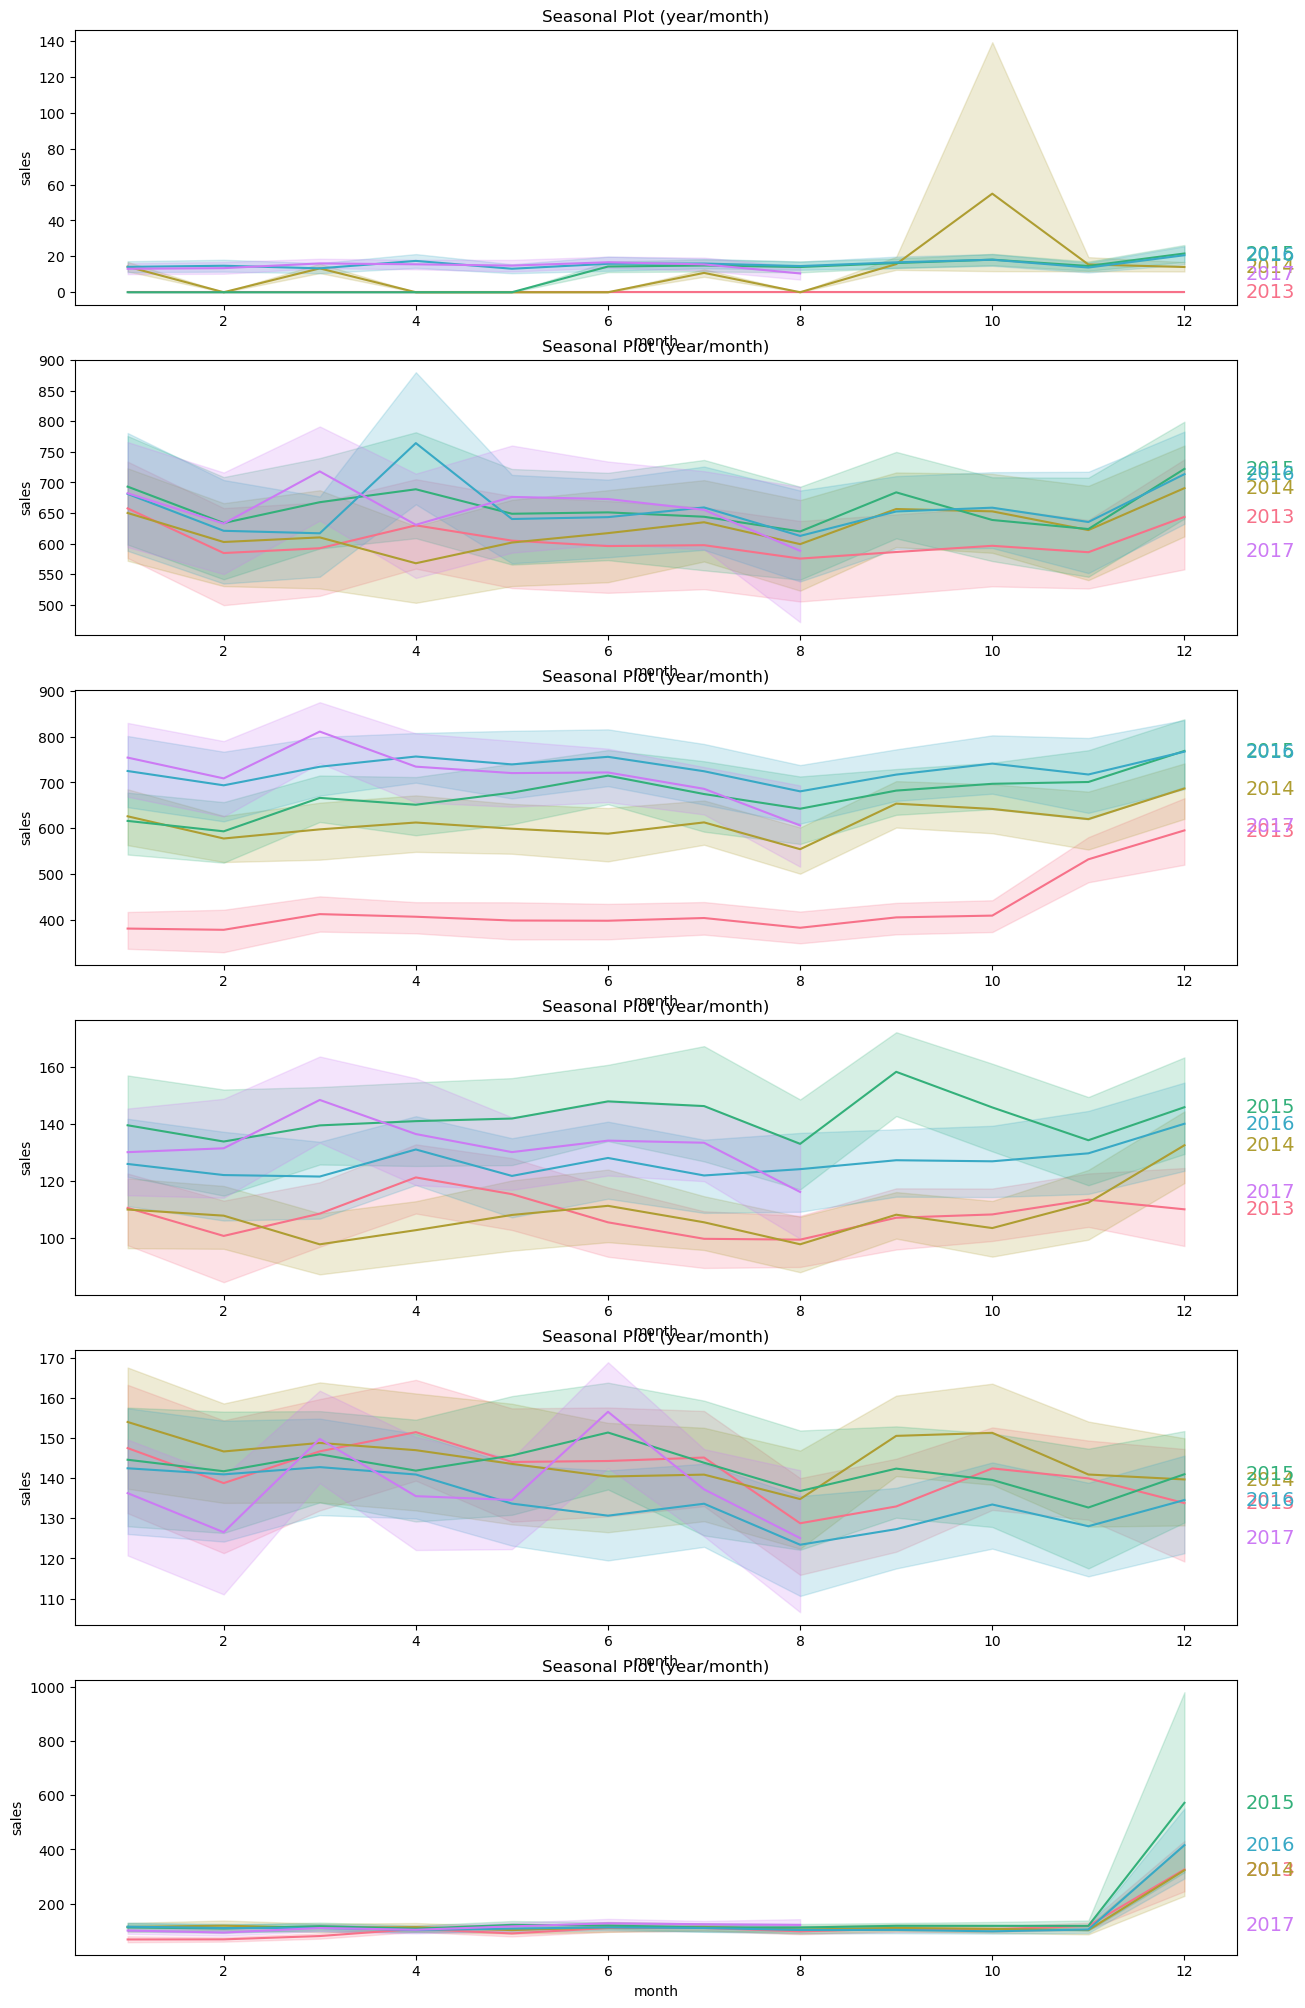

In [14]:
fig, axes = plt.subplots(6, 1, figsize = (15,25))
for n, ax in enumerate(fig.get_axes()):
    seasonal_plot(X = fl.loc[fl.family == cols[n+6], ['year', 'month']],
                  y = fl.loc[fl.family == cols[n+6], 'sales'], period = 'year', freq = 'month', ax=ax)
plt.show()

###### `In some cases there're yearly cycles`

#### Periodigram

/home/jovyan/work/store_sales/ts_tools.py:37: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

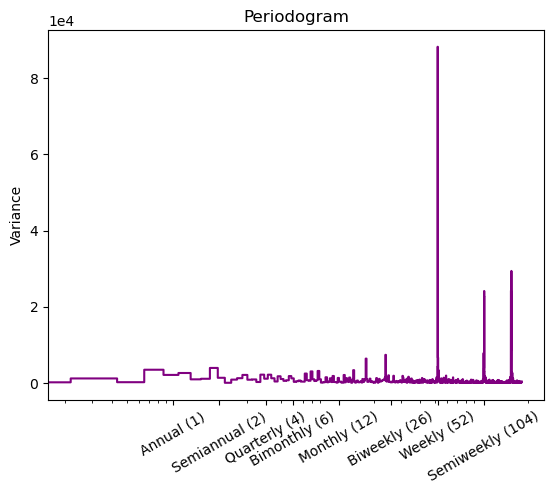

In [15]:
plot_periodogram(fl.loc[fl.family == cols[12], 'sales'].dropna())

###### `There're biweekly cycles also (maybe due to salaries on 15th and 30th)`

In [16]:
y = full.groupby(['date', 'store_nbr', 'family'])['sales'].mean().unstack(['store_nbr', 'family'])

In [17]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [18]:
fourier1 = CalendarFourier(freq='y', order=2)
fourier2 = CalendarFourier(freq='m', order=2)

In [19]:
dp = DeterministicProcess(y.index, order = 1, seasonal=True, additional_terms=[fourier1, fourier2])

In [20]:
X = dp.in_sample()

<AxesSubplot: xlabel='date'>

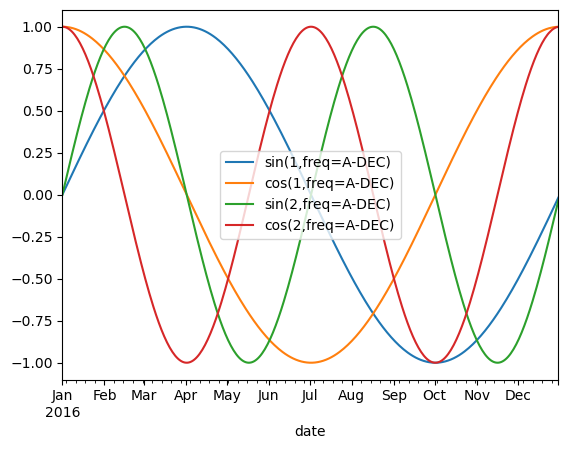

In [21]:
# annual terms
X.loc['2016', X.columns[-8:-4]].plot()

<AxesSubplot: xlabel='date'>

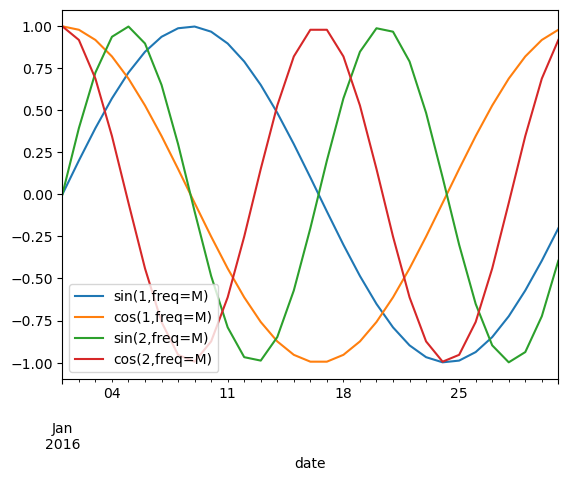

In [22]:
#monthly and biweekly
X.loc['2016-01', X.columns[-4:]].plot()

#### Deseason the data

In [26]:
y1 = y['1'].dropna()

In [26]:
y = fl.loc[fl.family == cols[12], 'sales'].dropna()

<AxesSubplot: xlabel='date'>

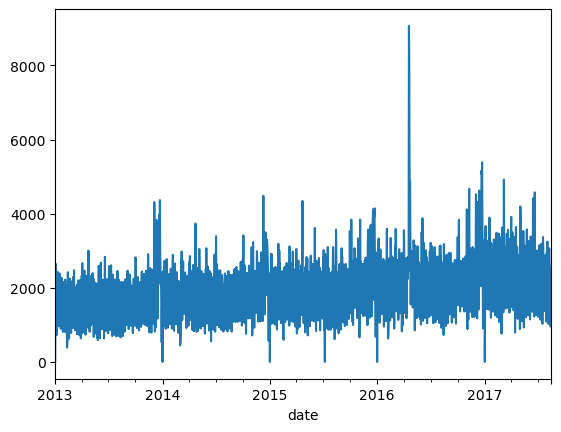

In [27]:
y.plot()

In [28]:
from catboost import CatBoostRegressor

In [29]:
rg = CatBoostRegressor(silent=True)

In [30]:
#del outliers
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()

In [31]:
outliers = lof.fit_predict(y.to_frame().dropna())

In [32]:
mask = outliers != -1

<AxesSubplot: xlabel='date'>

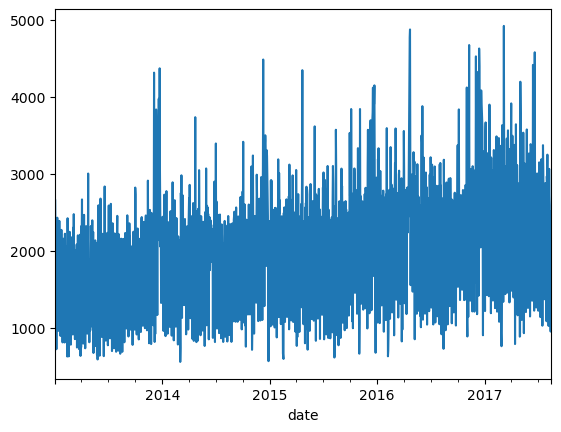

In [33]:
y = y.loc[mask]
y.plot()

In [34]:
y, X = y.align(X, axis=0, join = 'inner')

In [35]:
rg.fit(X, y)
y_pred = pd.Series(index = y.index, data = rg.predict(X))

In [36]:
y_deseason = y-y_pred

<AxesSubplot: xlabel='date'>

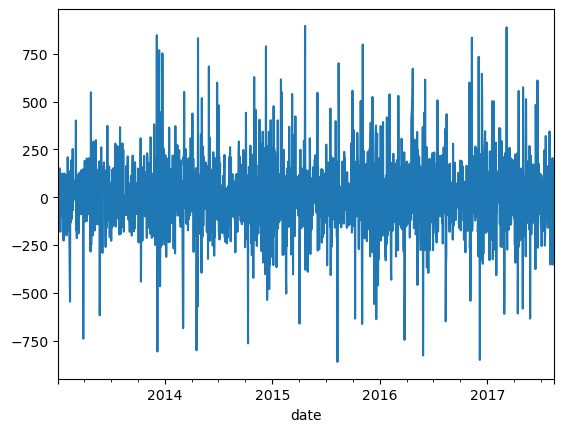

In [37]:
y_deseason.plot()

/home/jovyan/work/store_sales/ts_tools.py:37: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

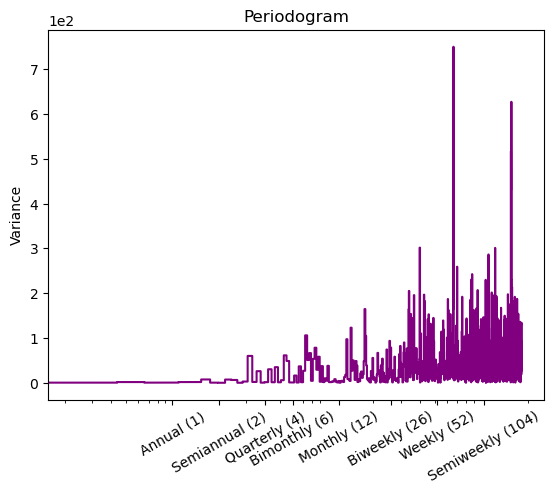

In [38]:
plot_periodogram(y_deseason)

##### `reduced for 2 orders`

### Work with other features

In [39]:
y

date
2013-01-02    2652.0
2013-01-03    2121.0
2013-01-04    2056.0
2013-01-05    2216.0
2013-01-06     723.0
               ...  
2017-08-11    1270.0
2017-08-12    1630.0
2017-08-13     952.0
2017-08-14    2407.0
2017-08-15    2508.0
Freq: D, Name: sales, Length: 1667, dtype: float32